In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from scipy.optimize import curve_fit
from scipy.stats.distributions import t
from scipy.optimize import minimize
from scipy import stats
import scipy.optimize as optimize

# Single response optimization

***Non-linear Regression Analysis to Determine the Model Parameters k, Kb , and Kt***

You can download Fogler's book from here:
https://doku.pub/download/h-scott-fogler-essentials-of-chemical-reaction-engineering-z0x2ze484wqn

# 1st method using lmfit

In [2]:
# observed experimental reaction rates for the reaction C6H5CH3 + H2 → C6H6 + CH4 or t + h → b + m
data = pd.DataFrame({"r":[71,71.3,41.6,19.7,42.0,17.1,71.8, 
142.0,284.0,47.0,71.3,117.0,127.0,131.0,133.0,41.8], 
"t":[1,1,1,1,1,1,1,1,1,0.5,1,5,10,15,20,1], "h":[1,1,1,1,1,1,1,2,4,1,1,1,1,1,1,1],
"m":[1,4,0,0,1,0,0,0,0,0,0,0,0,0,0,1], "b":[0,0,1,4,1,5,0,0,0,0,0,0,0,0,0,1]
})

# multiple independent variables - partial pressures of components
x_data = np.array([data["t"], data["h"], data["b"], data["m"]])

# dependent variable - rate of reaction
y_observed = data["r"]

df = data

In [3]:
# calculate y
def calc_y(x, k, Kb, Kt):
    
    num = k*x[0]*x[1]
    denom = 1+Kb*x[2]+Kt*x[0]
    y = num/denom #(mol/kg_cat.s)
    
    return y

my_model = Model(calc_y)

# set the boundries for each parameter
my_model.set_param_hint('k', min=0, max=200)
my_model.set_param_hint('Kb', min=0, max=150)
my_model.set_param_hint('Kt', min=0, max=150)

# initial values
result = my_model.fit(y_observed, x=x_data, k=0.05, Kb=200.0, Kt=1.0)

print(result.fit_report())

best_values = result.best_values
best_fit = result.best_fit

slope, intercept, r_value, p_value, std_err = stats.linregress(y_observed, best_fit)
    
# if r2 value is not close to one change the initial values
r2 = r_value**2
print('---------------------------------------------------------')
print('The value of r2 between the y_observed and y_calc is:', r2)

[[Model]]
    Model(calc_y)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # data points      = 16
    # variables        = 3
    chi-square         = 3.26050902
    reduced chi-square = 0.25080839
    Akaike info crit   = -19.4512864
    Bayesian info crit = -17.1335202
[[Variables]]
    k:   144.767308 +/- 0.57427659 (0.40%) (init = 0.05)
    Kb:  1.39052641 +/- 0.02120285 (1.52%) (init = 150)
    Kt:  1.03841056 +/- 0.00609291 (0.59%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, Kt)  = 0.957
    C(k, Kb)  = 0.343
    C(Kb, Kt) = 0.309
---------------------------------------------------------
The value of r2 between the y_observed and y_calc is: 0.9999530252449884


# Second method using Scipy curve_fit

In [4]:
# mol/kg_cat.s
def Rate(x, k, Kb, Kt):
    
    num = k*x[0]*x[1]
    denom = 1+Kb*x[2]+Kt*x[0]
    y = num/denom            
    
    return y

bnds = [0, [np.inf, np.inf, np.inf]]
    
popt, pcov = curve_fit(Rate, x_data, y_observed, p0 =[1.0, 1.0, 1.0], 
bounds = bnds)

#k value needs to be multiplied by 10^-10
k, Kb, Kt = popt

k_rate_constant = k*1e-10

residuals = Rate(x_data, *popt) - y_observed
rss = sum(residuals**2)

y_mean = np.mean(y_observed)
total_residuals = y_mean - y_observed
tss = sum(total_residuals**2)

n = len(y_observed) # number of data points
p = len(popt) # number of parameters
alpha = 0.05

dof = max(0, n - p) #number of degrees of freedom

r_squared = 1 - (rss/tss)
r_adjusted = 1 - ((1 - r_squared)*(n - 1))/(n - p - 1)

tinv = lambda alpha, dof: abs(t.ppf(1.0 - alpha/2, dof)) 
tval = tinv(alpha, dof)

#confidence level for the estimated parameters

dfit = np.sqrt(np.diag(pcov))
for i, j, var in zip(range(n), popt, dfit):
    print('j{0}: {1} [{2} {3}]'.format(i, j, j - var*tval, j + var*tval))
    
variance = rss/dof

rmse = (rss/n)**0.5

print("The rate constant value is: ", k_rate_constant)
print("The equilibrium constant of product b is", Kb)
print("The equilibrium constant of product t is", Kt)
print("The R squared value is:", r_squared)
print("The R_adjusted value is: ", r_adjusted)
print("The root mean square error (RMSE) or (RMSD) is", rmse)
print("The variance is", variance)

j0: 144.76730767069233 [143.5266570647402 146.00795827664447]
j1: 1.3905263980717728 [1.3447203893734294 1.4363324067701162]
j2: 1.0384105567359774 [1.0252475851572633 1.0515735283146914]
The rate constant value is:  1.4476730767069233e-08
The equilibrium constant of product b is 1.3905263980717728
The equilibrium constant of product t is 1.0384105567359774
The R squared value is: 0.9999509157577747
The R_adjusted value is:  0.9999386446972184
The root mean square error (RMSE) or (RMSD) is 0.451421990682046
The variance is 0.25080838605703537


# Third method using Scipy minimization, method = 'BFGS'

In [5]:
def kinet_params(data):

    y_calc = lambda x, k: k[0]*x[0]*x[1]/(1+k[1]*x[2]+k[2]*x[0])

    # Error function
    errFunc = lambda k, x, y: y_calc(x, k) - y

    # Error of parameters
    def errFit(hess_inv, resVariance):
        return np.sqrt(np.diag(hess_inv * resVariance))

    kstart = [0, 100, 0]
    
    # minimize, note that 'BFGS' method cannot handle bounds
    result = minimize(lambda k, x, y: (errFunc(k, x, y)**2).sum(), kstart, args=(x_data, y_observed), method = 'BFGS')
    
    dFit = errFit(result.hess_inv, result.fun/(len(y_observed)-len(kstart)))
    
    # best estimated parameters
    k = result.x
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_observed, y_calc(x_data, k))
    
    # if r2 value is not close to one change the initial values
    r2 = r_value**2
    
    # 95% confidence interval
    alpha = 0.05
    dof = max(0, len(y_observed) - len(k))
    
    tinv = lambda alpha, dof: abs(t.ppf(1.0 - alpha/2, dof))
    tval = tinv(alpha, dof)
    
    for i, j, var in zip(range(len(y_observed)), k, dFit):
        
        print('j{0}: {1} [{2}  {3}]'.format(i, j, j - var*tval, j + var*tval))

    return k, r2

kinet_params(data)

j0: 144.7673002082985 [144.60856263702195  144.92603777957507]
j1: 1.3905263346623833 [1.361215980684616  1.4198366886401506]
j2: 1.0384104735068629 [1.035231066253937  1.0415898807597888]


(array([144.76730021,   1.39052633,   1.03841047]), 0.9999530252384543)

# Fourth method using Scipy minimization, method = 'SLSQP'

In [6]:
def fun(x, *params):
    
    k, Kb, Kt = params
    
    num = k*x[0]*x[1]
    denom = 1+Kb*x[2]+Kt*x[0]
    y = num/denom 
    
    return y

def min_fun(params, x, y):
    
    k, Kb, Kt = params
    
    y_pred = fun(x, k, Kb, Kt)
    
    errFun = y_pred - y

    return (errFun**2).sum()

sol = minimize(min_fun, 
               [1, 1, 1], 
               args=(x_data, y_observed), 
               method='SLSQP',
               bounds=[(0.0, np.inf), (0.0, np.inf), (0.0, np.inf)])

slope, intercept, r_value, p_value, std_err = stats.linregress(y_observed, fun(x_data, k, Kb, Kt))

# if r2 value is not close to one change the initial values
r2 = r_value**2
print('The value of r2 between the y_observed and y_pred is:', r2)

sol.x

The value of r2 between the y_observed and y_pred is: 0.9999530252423822


array([144.76745725,   1.39052497,   1.0384117 ])

# 5th method with residuals plots

k  =  144.76730116752634
Kb  =  1.3905263772401588
Kt  =  1.0384104723919685


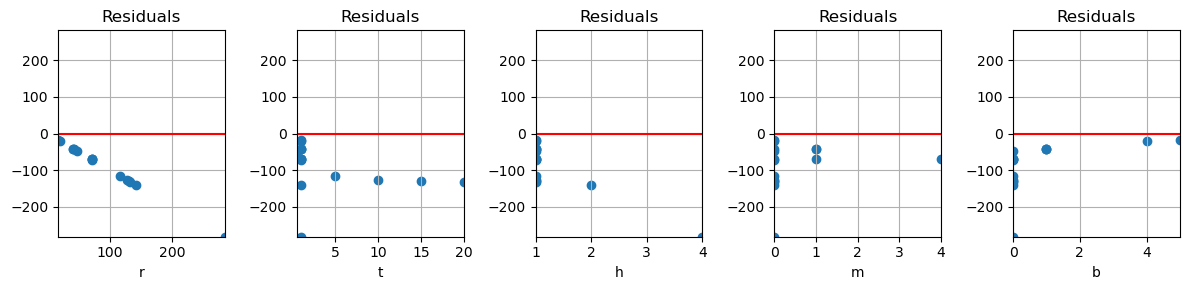

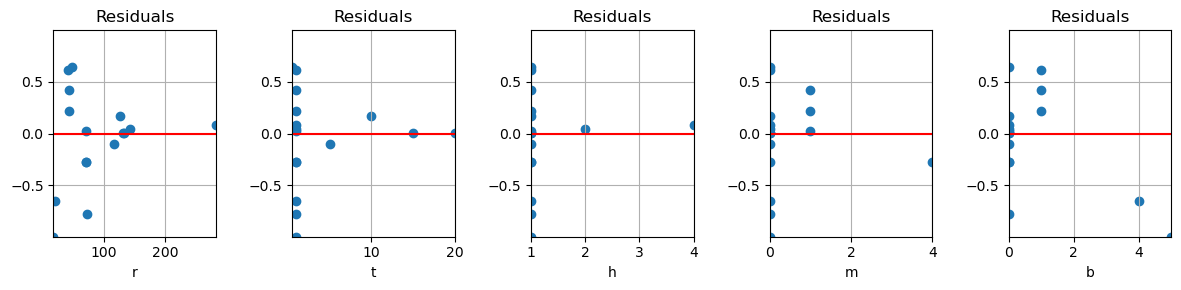

In [7]:
def residuals(parameters, df):
    
    k, Kb, Kt = parameters
    T, H, B, y_obs = data["t"], data["h"], data["b"], df["r"]
    
    num = k*T*H
    denom = 1+Kb*B+Kt*T
    y_pred = num/denom
    
    return y_pred - y_obs

parameter_names = ['k', 'Kb', 'Kt']
parameter_guess = [1, 1, 1]
parameter_bounds = [(0.0, np.inf), (0.0, np.inf), (0.0, np.inf)]

###################################################################
def plot_residuals(r, df, ax=None):
    rmax = np.max(np.abs(r))
    if ax is None:
        fig, ax = plt.subplots(1, len(df.columns), figsize=(12,3))
    else:
        rmax = max(ax[0].get_ylim()[1], rmax)
    n = 0
    for c in df.columns:
        ax[n].scatter(df[c], r)
        ax[n].set_ylim(-rmax, rmax)
        ax[n].set_xlim(min(df[c]), max(df[c]))
        ax[n].plot(ax[n].get_xlim(), [0,0], 'r')
        ax[n].set_xlabel(c)
        ax[n].set_title('Residuals') 
        ax[n].grid(True)
        n += 1
    plt.tight_layout()
###################################################################

def min_fun(parameters, df):
    
    return (residuals(parameters, df)**2).sum()

def best_fit(fcn, df):
    
    return minimize(fcn, 
               parameter_guess, 
               args=(df, ), 
               bounds = parameter_bounds)


parameter_fit = best_fit(min_fun, df)

for name, value in zip(parameter_names, parameter_fit.x):
    print(name, " = ", value)

r = residuals(parameter_guess, df)    
ax = plot_residuals(r, df)

r_best = residuals(parameter_fit.x, df)
plot_residuals(r_best, df, ax=ax)